# Abstract

To demonstrate the functionality of **state_at_date.foo** in a *tidy* manner, the following example provides a clear illustration using a single share and a few transactions.


# Set Up

In [1]:
# installing of linux packages needed for tidyplots
system("apt-get update -qq && apt-get install -y libcairo2-dev libxt-dev libjpeg-dev")

In [ ]:
# install tidyverse package
install.packages("tidyverse")

In [ ]:
# install tidyplots package
install.packages("tidyplots")

In [ ]:
# install tidyquant package
install.packages("tidyquant")

In [ ]:
# load R packages
library(tidyverse)
library(tidyplots)
library(tidyquant)

In [7]:
# load state_at_date function
source(url("https://raw.githubusercontent.com/iNANOV/transaction-state-simulator/main/state_at_date.R"))

In [16]:
# check if the state_at_date function is loaded
state_at_date.foo

function (acc, curr, initial_cash) 
{
    t <- tibble(value = curr) %>% separate(col = value, into = c("Close", 
        "amount", "price"), sep = "_") %>% mutate(across(everything(), 
        as.numeric))
    if (length(acc) == 0 || is.null(acc[[1]]) || nrow(acc[[1]]) == 
        0) {
        res <- list(open_positions = data.frame(id = seq_len(t$amount), 
            Close = t$Close, price = t$price), investment = t$price * 
            t$amount, cash = initial_cash - t$price * t$amount, 
            performance = (t$Close - t$price) * t$amount)
    }
    else {
        if (is.na(t$amount)) {
            open_positions_0 <- acc$open_positions %>% mutate(Close = t$Close)
            res <- list(open_positions = open_positions_0, investment = acc$investment, 
                cash = acc$cash, performance = open_positions_0 %>% 
                  mutate(return = Close - price) %>% pull(return) %>% 
                  sum())
        }
        else if (t$amount < 0) {
            open_positions_0 <- acc$open_positions %>% mutate(id = row_number()) %>% 
                select(-Close) %>% left_join(data.frame(id = seq_len(abs(t$amount)), 
                Close = t$price * -1), by = "id")
            res <- list(open_positions = filter(open_positions_0, 
                is.na(Close)) %>% mutate(Close = t$Close), investment = filter(open_positions_0, 
                is.na(Close)) %>% pull(price) %>% sum(), cash = filter(open_positions_0, 
                !is.na(Close)) %>% pull(Close) %>% sum() * -1 + 
                acc$cash, performance = filter(open_positions_0, 
                is.na(Close)) %>% mutate(Close = t$Close) %>% 
                mutate(return = Close - price) %>% pull(return) %>% 
                sum())
        }
        else if (t$amount > 0) {
            open_positions_0 <- acc$open_positions %>% mutate(Close = t$Close) %>% 
                bind_rows(data.frame(id = seq_len(t$amount), 
                  Close = t$Close, price = t$price))
            res <- list(open_positions = open_positions_0, investment = acc$investment + 
                t$amount * t$price, cash = acc$cash - t$amount * 
                t$price, performance = open_positions_0 %>% mutate(return = Close - 
                price) %>% pull(return) %>% sum())
        }
    }
    return(res)
}

# Processing

In [94]:
# example of a order book transactions
order_book <- data.frame(
  yahoo_ticker = "AAPL",
  cash_initial = 2000,
  date = as.Date(c("2023-10-02", "2023-10-12","2023-10-18","2023-10-20")),
  amount = c(10,-2,-6, 7), #  > 0 : buy; < 0 : sell
  price = c(172.23, 181.54, 177.65, 173.11)
  )

 order_book

yahoo_ticker,cash_initial,date,amount,price
<chr>,<dbl>,<date>,<dbl>,<dbl>
AAPL,2000,2023-10-02,10,172.23
AAPL,2000,2023-10-12,-2,181.54
AAPL,2000,2023-10-18,-6,177.65
AAPL,2000,2023-10-20,7,173.11


In [95]:
# Get stock prices for a stock from Yahoo
stock_prices <- tq_get(unique(order_book$yahoo_ticker), from = min(order_book$date), to = max(order_book$date)+1) %>%
  # make upper case on the first letter to all columns except 'date'
  rename_with(
    .fn = ~ ifelse(.x == "date", .x, paste0(toupper(substr(.x, 1, 1)), tolower(substr(.x, 2, nchar(.x))))),
    .cols = everything()
  )

stock_prices

Symbol,date,Open,High,Low,Close,Volume,Adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,2023-10-02,171.22,174.30,170.93,173.75,52164500,172.6754
AAPL,2023-10-03,172.26,173.63,170.82,172.40,49594600,171.3338
AAPL,2023-10-04,171.09,174.21,170.97,173.66,53020300,172.5860
AAPL,2023-10-05,173.79,175.45,172.68,174.91,48527900,173.8283
AAPL,2023-10-06,173.80,177.99,173.18,177.49,57224100,176.3923
AAPL,2023-10-09,176.81,179.05,175.80,178.99,42390800,177.8831
AAPL,2023-10-10,178.10,179.72,177.95,178.39,43698000,177.2868
AAPL,2023-10-11,178.20,179.85,177.60,179.80,47551100,178.6880
AAPL,2023-10-12,180.07,182.34,179.04,180.71,56743100,179.5924


In [96]:
# download stock data from yahoo finance and join it with the order book
stock_prices_and_order_book <- left_join(stock_prices, dplyr::select(order_book, -"yahoo_ticker"))

stock_prices_and_order_book

Joining with `by = join_by(date)`


Symbol,date,Open,High,Low,Close,Volume,Adjusted,cash_initial,amount,price
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,2023-10-02,171.22,174.30,170.93,173.75,52164500,172.6754,2000,10,172.23
AAPL,2023-10-03,172.26,173.63,170.82,172.40,49594600,171.3338,NA,NA,NA
AAPL,2023-10-04,171.09,174.21,170.97,173.66,53020300,172.5860,NA,NA,NA
AAPL,2023-10-05,173.79,175.45,172.68,174.91,48527900,173.8283,NA,NA,NA
AAPL,2023-10-06,173.80,177.99,173.18,177.49,57224100,176.3923,NA,NA,NA
AAPL,2023-10-09,176.81,179.05,175.80,178.99,42390800,177.8831,NA,NA,NA
AAPL,2023-10-10,178.10,179.72,177.95,178.39,43698000,177.2868,NA,NA,NA
AAPL,2023-10-11,178.20,179.85,177.60,179.80,47551100,178.6880,NA,NA,NA
AAPL,2023-10-12,180.07,182.34,179.04,180.71,56743100,179.5924,2000,-2,181.54


In [97]:
# calculation of open positinions, cash, investment and performance state for each date
options(warn = -1)

cumulative_state <- stock_prices_and_order_book %>%
  # unite the columns needed for performance tracking
  unite("Cap", Close, amount, price, sep = "_", remove = FALSE) %>%
  mutate(
    state = accumulate(
      Cap,
      function(acc, curr) {
        # Combine previous accumulator and current value
        state_at_date.foo(acc, curr, initial_cash = stock_prices_and_order_book$cash_initial[1])
      },
      .init = list() # Initial empty list
    ) %>%
      tail(-1) # Remove the initial value
  ) %>%
  dplyr::select(-Cap) %>%
  unnest_wider(state)

# remove the 'open_positions' column which contains list with the open positons for each date
dplyr::select(cumulative_state, -open_positions)

Symbol,date,Open,High,Low,Close,Volume,Adjusted,cash_initial,amount,price,investment,cash,performance
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,2023-10-02,171.22,174.30,170.93,173.75,52164500,172.6754,2000,10,172.23,1722.30,277.70,15.2000000
AAPL,2023-10-03,172.26,173.63,170.82,172.40,49594600,171.3338,NA,NA,NA,1722.30,277.70,1.6999390
AAPL,2023-10-04,171.09,174.21,170.97,173.66,53020300,172.5860,NA,NA,NA,1722.30,277.70,14.3000366
AAPL,2023-10-05,173.79,175.45,172.68,174.91,48527900,173.8283,NA,NA,NA,1722.30,277.70,26.8000366
AAPL,2023-10-06,173.80,177.99,173.18,177.49,57224100,176.3923,NA,NA,NA,1722.30,277.70,52.6000549
AAPL,2023-10-09,176.81,179.05,175.80,178.99,42390800,177.8831,NA,NA,NA,1722.30,277.70,67.6000549
AAPL,2023-10-10,178.10,179.72,177.95,178.39,43698000,177.2868,NA,NA,NA,1722.30,277.70,61.5999939
AAPL,2023-10-11,178.20,179.85,177.60,179.80,47551100,178.6880,NA,NA,NA,1722.30,277.70,75.7000305
AAPL,2023-10-12,180.07,182.34,179.04,180.71,56743100,179.5924,2000,-2,181.54,1377.84,640.78,67.8400537


In [84]:
# show the 'open_positions' column which contains list with the open positons for each date
dplyr::select(cumulative_state, date, open_positions) %>%
  unnest(open_positions)

date,id,Close,price
<date>,<int>,<dbl>,<dbl>
2023-10-02,1,173.75,172.23
2023-10-02,2,173.75,172.23
2023-10-02,3,173.75,172.23
2023-10-02,4,173.75,172.23
2023-10-02,5,173.75,172.23
2023-10-02,6,173.75,172.23
2023-10-02,7,173.75,172.23
2023-10-02,8,173.75,172.23
2023-10-02,9,173.75,172.23


# Quering

cash : initial cash + gains or loses of closed positions - investment;
 investment : invested capital in open positions;
 performance: performance from open positions


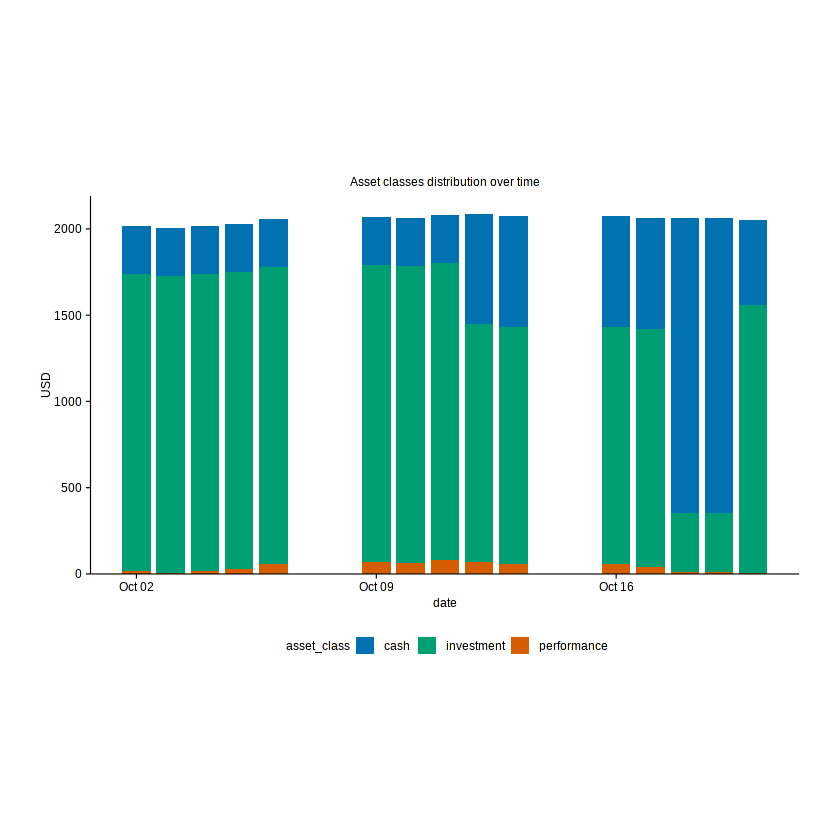

In [146]:
# Show summarized distribution over time

suppressMessages({
  cumulative_state %>%
    dplyr::select(- open_positions) %>%
    pivot_longer(
      cols = c("investment", "cash", "performance"), # Select columns to pivot
      names_to = "asset_class",        # New column for key names
      values_to = "usd"          # New column for values
    ) %>%
    group_by(date, asset_class) %>%
    summarise(USD = sum(usd)) %>%
    tidyplot(x = date, y = USD, color = asset_class,
            width = 150, height = 80) %>%
    add_barstack_absolute() %>%
    add_title("Asset classes distribution over time") %>%
    adjust_legend_position(position = "bottom")
})

cat("cash : initial cash + gains or loses of closed positions - investment;\n investment : invested capital in open positions;\n performance: performance from open positions\n")

Overall Performance: investment + cash + performance

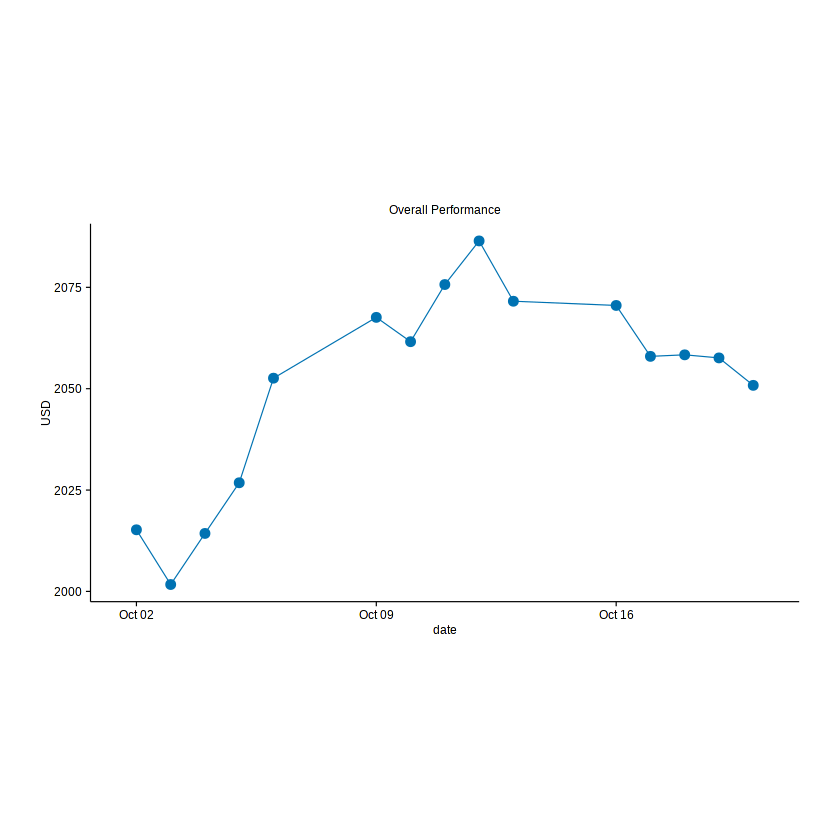

In [147]:
# Show overall performance in USD
cumulative_state %>%
  dplyr::select(- open_positions)  %>%
  mutate(USD = investment + cash + performance) %>%
  tidyplot(x = date, y = USD, width = 150, height = 80) %>%
  add_line() %>%
  add_mean_dot() %>%
  add_title("Overall Performance")

cat("Overall Performance: investment + cash + performance")

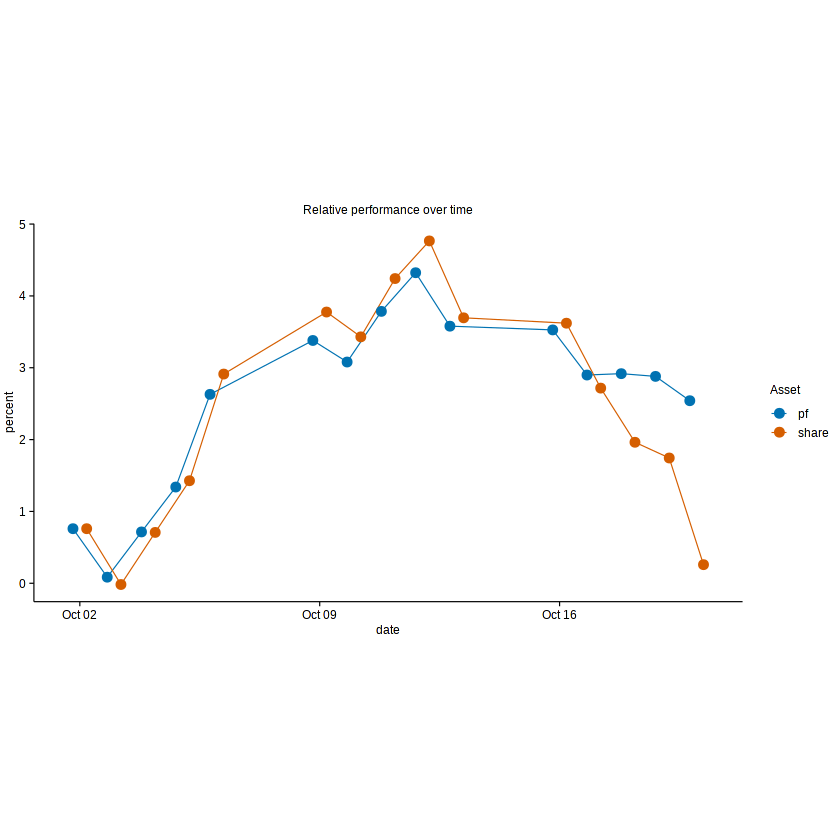

In [139]:
# Show relative performance of the portfolio and share in percent
cumulative_state %>%
  dplyr::select(date, Adjusted, investment, cash, performance)  %>%
  # calculating Port folio and share performance
  mutate(pf = 100*(((investment + cash + performance) / cumulative_state$cash_initial[1])-1),
         share = 100*(Adjusted-first(Adjusted))/first(Adjusted)) %>%
 # level adjustment
  mutate(share = share + first(pf)) %>%
  pivot_longer(
    cols = c("pf", "share"),
    names_to = "Asset",
    values_to = "percent"
  ) %>%
  tidyplot(x = date, y = percent, col = Asset, width = 150, height = 80) %>%
  add_mean_line() %>%
  add_mean_dot() %>%
  add_title("Relative performance over time")

cat("pf : Portfolio based on the order book\n share: AAPL ")